# Deforestation Data Cleaning

## Imports and Expirement Variables:

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import callbacks
from tensorflow.keras.metrics import AUC, Recall, Accuracy
from tensorflow.keras.preprocessing import image_dataset_from_directory


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#They are expirement variables that are meant to allow me to replicate the process with different models later
color_mode = 'rgb' #flow_from_dataframe
class_mode = 'binary' #flow_from_dataframe. For now, later on we will investigate multi-layer output
if color_mode == 'rgb': #control flow to build input layer of the model accordingly
    input_shape = (256,256,3)
elif color_mode == 'rgba':
    input_shape = (256,256,4)
image_train_path = 'drive/MyDrive/Colab Notebooks/notebooks_deforestation/data/train-jpg' #flow_from_dataframe
batch_size = 128  #expirement variable

## Data

In [49]:
#Load and inspect data
df = pd.read_csv('drive/MyDrive/Colab Notebooks/notebooks_deforestation/data/labels.csv')
df

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road
...,...,...
40474,train_40474,clear primary
40475,train_40475,cloudy
40476,train_40476,agriculture clear primary
40477,train_40477,agriculture clear primary road


### Label analysis 

In [6]:
labels = df['tags'].map(lambda x: x.split(' '))

In [7]:
all_labels = np.array([j for i in labels for j in i])
len(all_labels)

116278

In [8]:
counts = labels.map(lambda x: len(x))
np.max(counts)

9

(array([2.0910e+03, 1.9176e+04, 7.1920e+03, 7.1710e+03, 0.0000e+00,
        3.7000e+03, 9.9600e+02, 1.2700e+02, 2.4000e+01, 2.0000e+00]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. , 5.8, 6.6, 7.4, 8.2, 9. ]),
 <a list of 10 Patch objects>)

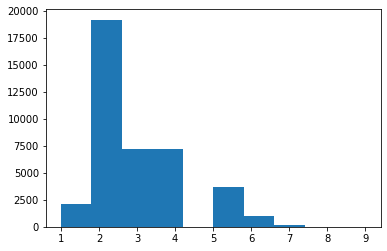

In [9]:
plt.hist(counts)

In [10]:
tags, freq = np.unique(all_labels, return_counts=True)

<BarContainer object of 17 artists>

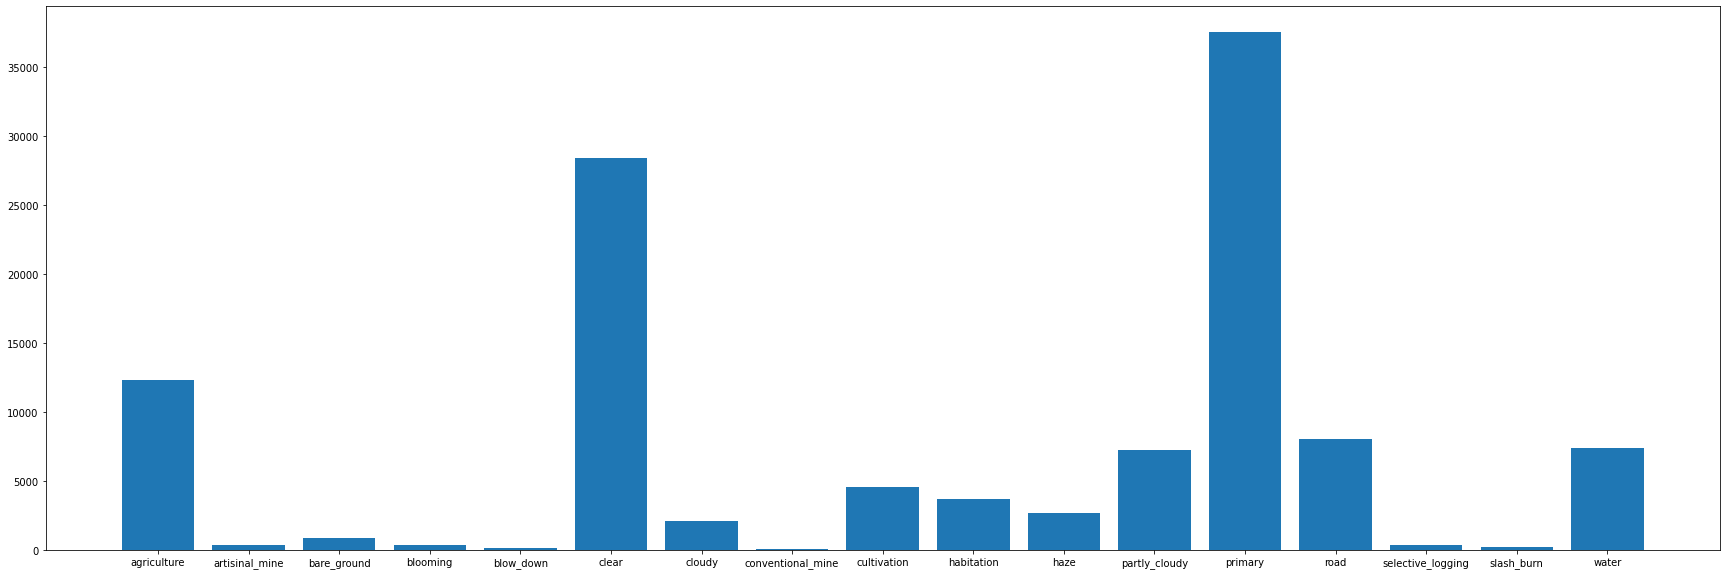

In [11]:
plt.figure(figsize=(30,10))
plt.bar(tags, freq)


In [17]:
labels[labels.map(lambda x: len(x)==1)]

12       [cloudy]
14       [cloudy]
26       [cloudy]
50       [cloudy]
68       [cloudy]
           ...   
40416    [cloudy]
40436    [cloudy]
40447    [cloudy]
40461    [cloudy]
40475    [cloudy]
Name: tags, Length: 2091, dtype: object

### Data preparation

In [12]:
def clean_row(row):
    '''
    labels of the data frame are a string that contains all landscapes that were detected by humans.
    At phase 1, we follow this logic: if there's just primary label (excluding weather and water)
    that's primary. If there's anything more then that- damaged.
    All cloudy photos and bare ground are None due to lack of valubale information.
    '''    
    label = 'damaged'
    kickout_labels = ['clear','cloudy', 'partly_cloudy', 'haze', 'blooming', 'water', 'blow_down', 'bare_ground']
    tags_list = row.split()
    tags_list_relevant = [word for word in tags_list if word not in kickout_labels]
  
    if len(tags_list_relevant) == 0:
        label = None
      
    elif tags_list_relevant == ['primary']:
        label = 'primary'
  
    return label
        

In [50]:
#Clean the original tags column and create a clean df. multiple path to expirement with flow_from_df

df['label'] = df['tags'].map(clean_row)
df['image_filename'] = df['image_name'].map(lambda x: f'{x}.jpg')
df['image_path'] = df['image_name'].map(lambda x: f'{image_train_path}/{x}.jpg')
df

,image_name,tags,label,image_filename,image_path
0,train_0,haze primary,primary,train_0.jpg,drive/MyDrive/Colab Notebooks/notebooks_defore...
1,train_1,agriculture clear primary water,damaged,train_1.jpg,drive/MyDrive/Colab Notebooks/notebooks_defore...
2,train_2,clear primary,primary,train_2.jpg,drive/MyDrive/Colab Notebooks/notebooks_defore...
3,train_3,clear primary,primary,train_3.jpg,drive/MyDrive/Colab Notebooks/notebooks_defore...
4,train_4,agriculture clear habitation primary road,damaged,train_4.jpg,drive/MyDrive/Colab Notebooks/notebooks_defore...
...,...,...,...,...,...
40474,train_40474,clear primary,primary,train_40474.jpg,drive/MyDrive/Colab Notebooks/notebooks_defore...
40475,train_40475,cloudy,None,train_40475.jpg,drive/MyDrive/Colab Notebooks/notebooks_defore...
40476,train_40476,agriculture clear primary,damaged,train_40476.jpg,drive/MyDrive/Colab Notebooks/notebooks_defore...
40477,train_40477,agriculture clear primary road,damaged,train_40477.jpg,drive/MyDrive/Colab Notebooks/notebooks_defore...


In [56]:
df_clean = df[['image_filename', 'label']].dropna()
df_clean
#WE might need to change that later on and un-drop the clouds columns, and only drop or ignore them in training.

,image_filename,label
0,train_0.jpg,primary
1,train_1.jpg,damaged
2,train_2.jpg,primary
3,train_3.jpg,primary
4,train_4.jpg,damaged
...,...,...
40473,train_40473.jpg,damaged
40474,train_40474.jpg,primary
40476,train_40476.jpg,damaged
40477,train_40477.jpg,damaged


In [ ]:
# #save for later use
# df_clean.to_csv('raw_data/train_clean_labels.csv', index = False)

In [ ]:
#Check
df_clean = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/deforestation/raw_data/train_clean_labels.csv', dtype = str)

In [54]:
df_clean

,image_filename,label
0,train_0.jpg,0.0
1,train_1.jpg,1.0
2,train_2.jpg,0.0
3,train_3.jpg,0.0
4,train_4.jpg,1.0
...,...,...
40473,train_40473.jpg,1.0
40474,train_40474.jpg,0.0
40476,train_40476.jpg,1.0
40477,train_40477.jpg,1.0


## Build Baseline Model

In [20]:
metrics = [AUC(), Recall(), Accuracy()]

In [21]:
def build_baseline():
    '''
    This model will be used as a fast baseline, and as a quick solution to my colleagues who work
    on production
    '''
    
    resnet50 = ResNet50(include_top = False, input_shape = input_shape)
    resnet50.trainable = False
    baseline = Sequential()
    baseline.add(resnet50)
    baseline.add(Flatten())
    baseline.add(Dense(1, activation = 'sigmoid'))
    
    baseline.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=metrics)   #recall is the way to go 
    return baseline

In [22]:
MODEL = "baseline_model"

mcp = callbacks.ModelCheckpoint("ML/models/{}.h5".format(MODEL), monitor="val_loss", verbose=0, save_best_only=True)

lrr = callbacks.ReduceLROnPlateau(monitor="val_loss", factor = 0.1, patience=3, verbose=1, min_lr=0)

es = callbacks.EarlyStopping(monitor='val_loss', patience=15, verbose=0, restore_best_weights=True)

cs = [mcp, lrr, es]



In [23]:
baseline_model = build_baseline()

94765736/94765736 [==============================] - 1s 0us/step


### Train Baseline Model

In [47]:
image_generator = ImageDataGenerator(validation_split = 0.2, rescale = 1./255)

In [80]:
train_generator = image_generator.flow_from_dataframe(
    dataframe = df_clean,
    directory = image_train_path,
    x_col = 'image_filename',
    y_col = 'label',
    color_mode = color_mode,
    class_mode = class_mode,
    batch_size = batch_size,
    subset = 'training',
    #validate_filenames = False
)

validation_generator = image_generator.flow_from_dataframe(
    dataframe = df_clean,
    directory = image_train_path,
    x_col = 'image_filename',
    y_col = 'label',
    color_mode = color_mode,
    class_moode = class_mode,
    batch_size = batch_size,
    subset = 'validation',
    #validate_filenames = False
)

/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:989: UserWarning: Found 37874 invalid image filename(s) in x_col="image_filename". These filename(s) will be ignored.
  warnings.warn('Found {} invalid image filename(s) in x_col="{}". '


Found 107 validated image filenames belonging to 2 classes.
Found 26 validated image filenames belonging to 2 classes.


In [78]:
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 1)                 131073    
                                                                 
Total params: 23,718,785
Trainable params: 131,073
Non-trainable params: 23,587,712
_________________________________________________________________


In [79]:
baseline_history = baseline_model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks = cs)

FileNotFoundError: ignored